TODO disaster selection:
* tornado higgest category : EF 5
* Earthquakes: 7.0 magnitude and higher
* hurricane max wind speed > 155 is category 5
* tornados, floods, and blizzards all in FEMA, so just use if declaration type is emergency

In [1]:
# Imports

%matplotlib inline

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

In [2]:
# Utils

def matches_date_regex(s):
    return bool(re.match(r'[0-9]{4}-[0-9]{2}-[0-9]{2}', s))

def get_prices_from_housing_data(df):
    return df[[x for x in df.columns if matches_date_regex(x)]]

def get_average_prices_for_years(housing_data, years, output_column):
    str_years = [str(y) for y in years]
    housing_data[output_column] = get_prices_from_housing_data(
        housing_data
    )[[
        x for x in housing_data.columns
        if x[:4] in str_years
    ]].T.mean()

def get_average_price_changes_for_years(housing_data, years, output_column):
    str_years = [str(y) for y in years]
    housing_data[output_column] = get_prices_from_housing_data(
        housing_data
    )[[
        x for x in housing_data.columns
        if x[:4] in str_years
    ]].T.pct_change().mean()

def calculate_distances_to_disaster(housing_data, disaster_latitudes, disaster_longitudes, output_column):
    temp_housing_data = housing_data
    coords = list(zip(disaster_latitudes, disaster_longitudes))

    if output_column in temp_housing_data:
        del temp_housing_data[output_column]

    for i in range(len(coords)):
        dist = np.sqrt(
            (temp_housing_data['clat10'] - coords[i][0]) ** 2 +
            (temp_housing_data['clon10'] - coords[i][1]) ** 2
        )
        if output_column not in temp_housing_data:
            temp_housing_data[output_column] = dist
        else:
            d = {}
            d[output_column] = dist
            df = pd.DataFrame(d)
            temp_housing_data = temp_housing_data.combine(df, np.minimum, overwrite=False)

    housing_data[output_column] = temp_housing_data[output_column]

def filter_housing_data_by_years(housing_data, years):
    str_years = [str(y) for y in years]
    return housing_data[[
        x for x in housing_data.columns
        if x[:4] in str_years or not matches_date_regex(x)
    ]].dropna(thresh=26)

In [3]:
# Input data setup

dataset_selection = {
    '188-million-us-wildfires': [
        'FPA_FOD_20170508.sqlite',
    ],
    'county-centers' : [
        'county_centers.csv',
    ],
    'federal-disasters': [
        'database.csv',
    ],
    'hurricane-database': [
        'atlantic.csv',
        'pacific.csv',
    ],
    'earthquake-database': [
        'database.csv',
    ],
    'zhvi-county': [
        'County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon (4).csv',
    ],
}


# Dataframe generation

available_datasets = os.listdir('/kaggle/input')
print(f'Available datasets: {available_datasets}')

datasets = {}
num_datasets = 0

for name, files in dataset_selection.items():
    datasets[name] = [x for x in os.listdir(f'/kaggle/input/{name}') if x in files]
    num_datasets += len(datasets[name])

print(f'{num_datasets} datasets loaded: {datasets}')

def read_file(filename):
    if filename[-4:] == '.csv':
        return pd.read_csv(filename)
    elif filename[-7:] == '.sqlite':
        con = sqlite3.connect(filename)
        result = pd.read_sql_query("SELECT * from fires", con)
        con.close()
        return result
    return None

data = {}

for name, files in datasets.items():
    data[name] = {x[0]: x[1] for x in [(file, read_file(f'/kaggle/input/{name}/{file}')) for file in files]}


# Dataframe variables

wildfires_data = data['188-million-us-wildfires']['FPA_FOD_20170508.sqlite']
counties_data = data['county-centers']['county_centers.csv']
disasters_data = data['federal-disasters']['database.csv']
hurricane_atlantic_data = data['hurricane-database']['atlantic.csv']
hurricane_pacific_data = data['hurricane-database']['pacific.csv']
earthquake_data = data['earthquake-database']['database.csv']
housing_data = data['zhvi-county']['County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon (4).csv']

Available datasets: ['earthquake-database', 'federal-disasters', 'zhvi-county', 'hurricane-database', 'county-centers', '188-million-us-wildfires']
7 datasets loaded: {'188-million-us-wildfires': ['FPA_FOD_20170508.sqlite'], 'county-centers': ['county_centers.csv'], 'federal-disasters': ['database.csv'], 'hurricane-database': ['atlantic.csv', 'pacific.csv'], 'earthquake-database': ['database.csv'], 'zhvi-county': ['County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon (4).csv']}


In [4]:
wildfires_data

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,...,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,...,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1880460,1880461,300348363,2015CAIRS29019636,NONFED,ST-CACDF,ST/C&L,USCASHU,Shasta-Trinity Unit,CASHU,Shasta-Trinity Unit,...,A,40.481637,-122.389375,13.0,STATE OR PRIVATE,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00P\xb8\x1e\x85\xeb\x9...
1880461,1880462,300348373,2015CAIRS29217935,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
1880462,1880463,300348375,2015CAIRS28364460,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,A,37.617619,-120.938570,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00\x00\x80\xbe\x88\x11...
1880463,1880464,300348377,2015CAIRS29218079,NONFED,ST-CACDF,ST/C&L,USCATCU,Tuolumne-Calaveras Unit,CATCU,Tuolumne-Calaveras Unit,...,B,37.672235,-120.898356,12.0,MUNICIPAL/LOCAL,CA,None,None,None,b'\x00\x01\xad\x10\x00\x00x\xba_\xaa~9^\xc0\xb...


In [5]:
counties_data

,fips,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10
0,1001,-86.577176,32.523283,-86.644490,32.536382,-86.501832,32.500323,-86.494165,32.500389
1,1003,-87.748260,30.592781,-87.746067,30.659218,-87.760540,30.565383,-87.762381,30.548923
2,1005,-85.331312,31.856515,-85.405456,31.870670,-85.306746,31.847869,-85.310038,31.844036
3,1007,-87.123243,33.040054,-87.127148,33.015893,-87.127019,33.025947,-87.127659,33.030921
4,1009,-86.554768,33.978461,-86.567246,33.977448,-86.582617,33.962601,-86.591491,33.955243
...,...,...,...,...,...,...,...,...,...
3142,56037,-109.168198,41.640708,-108.875676,41.660339,-109.302230,41.577416,-109.295115,41.580266
3143,56039,-110.673534,43.612124,-110.588102,44.049320,-110.779920,43.501456,-110.784353,43.494174
3144,56041,-110.599878,41.283917,-110.558947,41.284726,-110.771650,41.273058,-110.767519,41.271860
3145,56043,-107.728972,43.960220,-107.669052,43.878831,-107.909260,44.011935,-107.911552,44.012142


In [6]:
disasters_data

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,Individual Assistance Program,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program
0,DR-1,Disaster,05/02/1953,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,Yes,No,Yes,Yes
1,DR-2,Disaster,05/15/1953,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,Yes,No,Yes,Yes
2,DR-3,Disaster,05/29/1953,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,Yes,No,Yes,Yes
3,DR-4,Disaster,06/02/1953,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,Yes,No,Yes,Yes
4,DR-5,Disaster,06/06/1953,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,Yes,No,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46180,DR-4301,Disaster,02/14/2017,CA,Sutter County,Storm,"Severe Winter Storms, Flooding, and Mudslides",01/03/2017,01/12/2017,NaN,No,No,Yes,Yes
46181,DR-4301,Disaster,02/14/2017,CA,Trinity County,Storm,"Severe Winter Storms, Flooding, and Mudslides",01/03/2017,01/12/2017,NaN,No,No,Yes,Yes
46182,DR-4301,Disaster,02/14/2017,CA,Tuolumne County,Storm,"Severe Winter Storms, Flooding, and Mudslides",01/03/2017,01/12/2017,NaN,No,No,Yes,Yes
46183,DR-4301,Disaster,02/14/2017,CA,Yolo County,Storm,"Severe Winter Storms, Flooding, and Mudslides",01/03/2017,01/12/2017,NaN,No,No,Yes,Yes


In [7]:
hurricane_atlantic_data

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0N,94.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0N,95.4W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0N,96.0W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1N,96.5W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2N,96.8W,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,1200,,EX,41.3N,50.4W,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9N,49.9W,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5N,49.2W,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8N,47.5W,45,985,...,180,220,0,0,0,0,0,0,0,0


In [8]:
try:
    hurricane_atlantic_data['Latitude'] = hurricane_atlantic_data['Latitude'].apply(lambda x: float(x[:-1]) * (-1 if x[-1] == 'S' else 1))
except:
    pass
try:
    hurricane_atlantic_data['Longitude'] = hurricane_atlantic_data['Longitude'].apply(lambda x: float(x[:-1]) * (-1 if x[-1] == 'W' else 1))
except:
    pass

hurricane_atlantic_data

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,AL011851,UNNAMED,18510625,0,,HU,28.0,-94.8,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,AL011851,UNNAMED,18510625,600,,HU,28.0,-95.4,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,AL011851,UNNAMED,18510625,1200,,HU,28.0,-96.0,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,AL011851,UNNAMED,18510625,1800,,HU,28.1,-96.5,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,AL011851,UNNAMED,18510625,2100,L,HU,28.2,-96.8,80,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49100,AL122015,KATE,20151112,1200,,EX,41.3,-50.4,55,981,...,180,120,120,120,60,0,0,0,0,0
49101,AL122015,KATE,20151112,1800,,EX,41.9,-49.9,55,983,...,180,120,120,120,60,0,0,0,0,0
49102,AL122015,KATE,20151113,0,,EX,41.5,-49.2,50,985,...,200,220,120,120,60,0,0,0,0,0
49103,AL122015,KATE,20151113,600,,EX,40.8,-47.5,45,985,...,180,220,0,0,0,0,0,0,0,0


In [9]:
hurricane_pacific_data

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
0,EP011949,UNNAMED,19490611,0,,TS,20.2N,106.3W,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
1,EP011949,UNNAMED,19490611,600,,TS,20.2N,106.4W,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
2,EP011949,UNNAMED,19490611,1200,,TS,20.2N,106.7W,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
3,EP011949,UNNAMED,19490611,1800,,TS,20.3N,107.7W,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
4,EP011949,UNNAMED,19490612,0,,TS,20.4N,108.6W,45,-999,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26132,EP222015,SANDRA,20151128,1200,,LO,21.7N,109.0W,35,1002,...,0,0,0,0,0,0,0,0,0,0
26133,EP222015,SANDRA,20151128,1800,,LO,22.4N,108.7W,30,1007,...,0,0,0,0,0,0,0,0,0,0
26134,EP222015,SANDRA,20151129,0,,LO,23.1N,108.3W,30,1008,...,0,0,0,0,0,0,0,0,0,0
26135,EP222015,SANDRA,20151129,600,,LO,23.5N,107.9W,25,1009,...,0,0,0,0,0,0,0,0,0,0


In [10]:
earthquake_data

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.2460,145.6160,Earthquake,131.60,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.8630,127.3520,Earthquake,80.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.5790,-173.9720,Earthquake,20.00,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.0760,-23.5570,Earthquake,15.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.9380,126.4270,Earthquake,15.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,Earthquake,12.30,1.2,40.0,5.6,ML,...,18.0,42.47,0.120,NaN,0.1898,NN00570710,NN,NN,NN,Reviewed
23408,12/28/2016,09:13:47,38.3777,-118.8957,Earthquake,8.80,2.0,33.0,5.5,ML,...,18.0,48.58,0.129,NaN,0.2187,NN00570744,NN,NN,NN,Reviewed
23409,12/28/2016,12:38:51,36.9179,140.4262,Earthquake,10.00,1.8,NaN,5.9,MWW,...,NaN,91.00,0.992,4.8,1.5200,US10007NAF,US,US,US,Reviewed
23410,12/29/2016,22:30:19,-9.0283,118.6639,Earthquake,79.00,1.8,NaN,6.3,MWW,...,NaN,26.00,3.553,6.0,1.4300,US10007NL0,US,US,US,Reviewed


In [11]:
if 'FIPS' in housing_data:
    del housing_data['FIPS']
if 'clon10' in housing_data:
    del housing_data['clon10']
if 'clat10' in housing_data:
    del housing_data['clat10']

concat_fips = housing_data[['StateCodeFIPS', 'MunicipalCodeFIPS']].apply(lambda x: int(''.join([
    '00' + str(x[i]) if x[i] < 10
    else '0' + str(x[i]) if x[i] < 100
    else str(x[i])
    for i in range(len(x))
])), axis=1)

housing_data['FIPS'] = concat_fips

housing_data = pd.concat([housing_data.set_index('FIPS'), counties_data[['fips', 'clon10', 'clat10']].set_index('fips')], axis=1, join='inner')

housing_data.reset_index(drop=True)
counties_data.reset_index(drop=True)

housing_data['avg_price'] = get_prices_from_housing_data(housing_data).T.mean()
housing_data['avg_price_change'] = get_prices_from_housing_data(housing_data).T.pct_change().mean()

housing_data

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,1996-01-31,...,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,clon10,clat10,avg_price,avg_price_change
6037,3101,0,Los Angeles County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,37,174806.0,...,652573.0,654414.0,655794.0,661051.0,668812.0,677628.0,-118.261862,34.196398,410148.074074,0.004630
17031,139,1,Cook County,County,IL,IL,Chicago-Naperville-Elgin,17,31,157181.0,...,258413.0,259057.0,259963.0,261565.0,263624.0,266504.0,-87.645455,41.894294,227501.922559,0.001811
48201,1090,2,Harris County,County,TX,TX,Houston-The Woodlands-Sugar Land,48,201,100825.0,...,203388.0,204435.0,205211.0,206161.0,207293.0,209145.0,-95.393037,29.857273,140084.925926,0.002475
4013,2402,3,Maricopa County,County,AZ,AZ,Phoenix-Mesa-Scottsdale,4,13,115807.0,...,301917.0,305069.0,307947.0,310740.0,314456.0,318895.0,-112.495534,33.346541,197261.474747,0.003489
6073,2841,4,San Diego County,County,CA,CA,San Diego-Carlsbad,6,73,177310.0,...,607043.0,610945.0,613668.0,617391.0,623359.0,632264.0,-116.776117,33.023604,404767.420875,0.004345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16025,425,3101,Camas County,County,ID,ID,Hailey,16,25,NaN,...,152946.0,153614.0,154370.0,155290.0,156251.0,157501.0,-114.804427,43.463396,125456.993464,-0.000077
49009,1648,3102,Daggett County,County,UT,UT,NaN,49,9,NaN,...,197781.0,198238.0,198682.0,199726.0,200607.0,201642.0,-109.505785,40.890099,151774.058824,0.004837
8053,2345,3112,Hinsdale County,County,CO,CO,NaN,8,53,NaN,...,367083.0,366892.0,366824.0,368134.0,368727.0,369449.0,-107.383405,37.811625,353830.608696,0.003064
8079,1933,3122,Mineral County,County,CO,CO,NaN,8,79,NaN,...,275602.0,275883.0,276154.0,276582.0,277249.0,278179.0,-106.932300,37.651478,262989.444444,0.001345


In [12]:
# Hurricane selection

hname = 'katrina'
hyear = 2005

hurricane_atlantic_data_selected = hurricane_atlantic_data[
    (hurricane_atlantic_data['Name'] == (' '*(19-len(hname)))+hname.upper())
    & (hurricane_atlantic_data['Date'] > hyear*10000)
]

hurricane_atlantic_data_selected

,ID,Name,Date,Time,Event,Status,Latitude,Longitude,Maximum Wind,Minimum Pressure,...,Low Wind SW,Low Wind NW,Moderate Wind NE,Moderate Wind SE,Moderate Wind SW,Moderate Wind NW,High Wind NE,High Wind SE,High Wind SW,High Wind NW
44063,AL122005,KATRINA,20050823,1800,,TD,23.1,-75.1,30,1008,...,0,0,0,0,0,0,0,0,0,0
44064,AL122005,KATRINA,20050824,0,,TD,23.4,-75.7,30,1007,...,0,0,0,0,0,0,0,0,0,0
44065,AL122005,KATRINA,20050824,600,,TD,23.8,-76.2,30,1007,...,0,0,0,0,0,0,0,0,0,0
44066,AL122005,KATRINA,20050824,1200,,TS,24.5,-76.5,35,1006,...,0,0,0,0,0,0,0,0,0,0
44067,AL122005,KATRINA,20050824,1800,,TS,25.4,-76.9,40,1003,...,0,0,0,0,0,0,0,0,0,0
44068,AL122005,KATRINA,20050825,0,,TS,26.0,-77.7,45,1000,...,0,0,0,0,0,0,0,0,0,0
44069,AL122005,KATRINA,20050825,600,,TS,26.1,-78.4,50,997,...,0,0,15,0,0,0,0,0,0,0
44070,AL122005,KATRINA,20050825,1200,,TS,26.2,-79.0,55,994,...,30,50,20,20,0,0,0,0,0,0
44071,AL122005,KATRINA,20050825,1800,,TS,26.2,-79.6,60,988,...,50,60,25,25,20,20,0,0,0,0
44072,AL122005,KATRINA,20050825,2230,L,HU,26.0,-80.1,70,984,...,-999,-999,-999,-999,-999,-999,-999,-999,-999,-999


In [13]:
# Hurricane distance calculation

calculate_distances_to_disaster(housing_data, hurricane_atlantic_data_selected['Latitude'], hurricane_atlantic_data_selected['Longitude'], 'hurricane_dist')

housing_data

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,1996-01-31,...,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,clon10,clat10,avg_price,avg_price_change,hurricane_dist
6037,3101,0,Los Angeles County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,37,174806.0,...,654414.0,655794.0,661051.0,668812.0,677628.0,-118.261862,34.196398,410148.074074,0.004630,28.828632
17031,139,1,Cook County,County,IL,IL,Chicago-Naperville-Elgin,17,31,157181.0,...,259057.0,259963.0,261565.0,263624.0,266504.0,-87.645455,41.894294,227501.922559,0.001811,4.043950
48201,1090,2,Harris County,County,TX,TX,Houston-The Woodlands-Sugar Land,48,201,100825.0,...,204435.0,205211.0,206161.0,207293.0,209145.0,-95.393037,29.857273,140084.925926,0.002475,5.803166
4013,2402,3,Maricopa County,County,AZ,AZ,Phoenix-Mesa-Scottsdale,4,13,115807.0,...,305069.0,307947.0,310740.0,314456.0,318895.0,-112.495534,33.346541,197261.474747,0.003489,23.005487
6073,2841,4,San Diego County,County,CA,CA,San Diego-Carlsbad,6,73,177310.0,...,610945.0,613668.0,617391.0,623359.0,632264.0,-116.776117,33.023604,404767.420875,0.004345,27.244111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16025,425,3101,Camas County,County,ID,ID,Hailey,16,25,NaN,...,153614.0,154370.0,155290.0,156251.0,157501.0,-114.804427,43.463396,125456.993464,-0.000077,27.827058
49009,1648,3102,Daggett County,County,UT,UT,NaN,49,9,NaN,...,198238.0,198682.0,199726.0,200607.0,201642.0,-109.505785,40.890099,151774.058824,0.004837,21.980839
8053,2345,3112,Hinsdale County,County,CO,CO,NaN,8,53,NaN,...,366892.0,366824.0,368134.0,368727.0,369449.0,-107.383405,37.811625,353830.608696,0.003064,19.007772
8079,1933,3122,Mineral County,County,CO,CO,NaN,8,79,NaN,...,275883.0,276154.0,276582.0,277249.0,278179.0,-106.932300,37.651478,262989.444444,0.001345,18.529179


In [14]:
# Housing data filter for selected hurricane

hurricane_max_dist = 2
hurricane_years = range(2005, 2009)

get_average_prices_for_years(housing_data, hurricane_years, 'hurricane_avg_price')
get_average_price_changes_for_years(housing_data, hurricane_years, 'hurricane_avg_price_change')

hurricane_housing_data = housing_data[
    housing_data['hurricane_dist'] < hurricane_max_dist
]

hurricane_housing_data

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,1996-01-31,...,2020-07-31,2020-08-31,2020-09-30,clon10,clat10,avg_price,avg_price_change,hurricane_dist,hurricane_avg_price,hurricane_avg_price_change
12086,2964,7,Miami-Dade County,County,FL,FL,Miami-Fort Lauderdale-West Palm Beach,12,86,113533.0,...,324275.0,326140.0,328391.0,-80.499045,25.610494,218047.151515,0.003654,0.351330,314574.729167,-0.000467
12011,1561,17,Broward County,County,FL,FL,Miami-Fort Lauderdale-West Palm Beach,12,11,98825.0,...,282979.0,284218.0,285870.0,-80.476658,26.193520,187539.037037,0.003649,0.342581,263362.062500,-0.002509
12099,2993,27,Palm Beach County,County,FL,FL,Miami-Fort Lauderdale-West Palm Beach,12,99,115072.0,...,297281.0,299744.0,303097.0,-80.448673,26.645763,205137.952862,0.003324,0.733882,283918.833333,-0.002755
39049,2288,32,Franklin County,County,OH,OH,Columbus,39,49,103219.0,...,206028.0,208268.0,210547.0,-83.008258,39.969447,139944.148148,0.002420,0.169599,148907.812500,-0.000523
47157,1388,46,Shelby County,County,TN,TN,Memphis,47,157,100254.0,...,154082.0,155796.0,157363.0,-89.895397,35.183794,119801.673401,0.001538,1.688983,135956.437500,-0.001981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21039,2175,2831,Carlisle County,County,KY,KY,NaN,21,39,NaN,...,76974.0,77210.0,77512.0,-88.975757,36.857726,64097.408759,0.002257,1.591847,NaN,NaN
47137,1973,2834,Pickett County,County,TN,TN,NaN,47,137,38333.0,...,126231.0,126643.0,127036.0,-85.075741,36.559364,82253.299663,0.004074,1.974065,88328.145833,0.003306
21105,1772,2844,Hickman County,County,KY,KY,NaN,21,105,NaN,...,72358.0,72560.0,72831.0,-88.972020,36.675916,63267.707143,0.001481,1.449972,NaN,NaN
17151,297,2867,Pope County,County,IL,IL,NaN,17,151,NaN,...,158006.0,155756.0,152745.0,-88.542374,37.417169,153088.400000,0.001453,1.597795,NaN,NaN


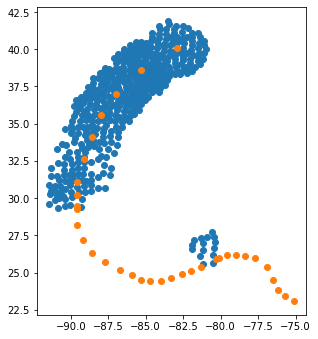

In [15]:
# Selected hurricane visualization

lat_range = hurricane_atlantic_data_selected['Latitude'].max() - hurricane_atlantic_data_selected['Latitude'].min()
long_range = hurricane_atlantic_data_selected['Longitude'].max() - hurricane_atlantic_data_selected['Longitude'].min()

plt.figure(figsize=(long_range / 3, lat_range / 3))
plt.scatter(hurricane_housing_data['clon10'], hurricane_housing_data['clat10'])
plt.scatter(hurricane_atlantic_data_selected['Longitude'], hurricane_atlantic_data_selected['Latitude'])

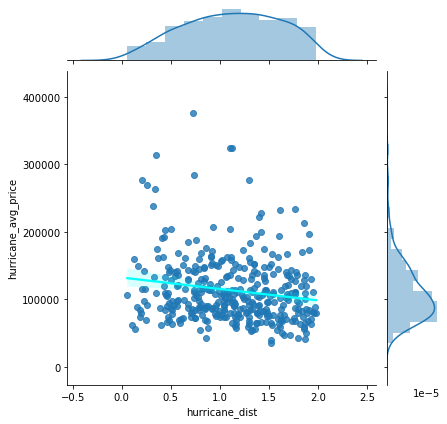

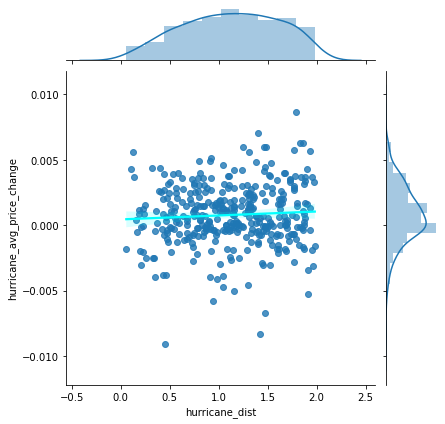

In [16]:
# Linear regression on housing distances to selected hurricane

sns.jointplot(x="hurricane_dist", y="hurricane_avg_price", data=hurricane_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})
sns.jointplot(x="hurricane_dist", y="hurricane_avg_price_change", data=hurricane_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})

In [17]:
# Wildfire selection

wsizes = ['G']

wildfires_data_selected = wildfires_data[
    wildfires_data['FIRE_SIZE_CLASS'].isin(wsizes)
].sample(100)

wildfires_data_selected

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
172254,172255,173939,FS-402781,FED,FS-FIRESTAT,FS,USNMCIF,Cibola National Forest,0303,Cibola National Forest,...,G,34.303056,-105.797222,5.0,USFS,NM,57,057,Torrance,b'\x00\x01\xad\x10\x00\x00\xd8\xa2X\xb0\x05sZ\...
305416,305417,311209,W-110048,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,...,G,65.526300,-144.591100,7.0,STATE,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00L\x15\x8cJ\xea\x12b\...
1522686,1522687,201335316,TFS-TX2009-75053,NONFED,ST-TXTXS,ST/C&L,USTXWZS,Texas Forest Service - West Zone,TXWZS,Texas Forest Service - West Branch,...,G,32.488833,-98.975667,13.0,STATE OR PRIVATE,TX,Eastland,133,Eastland,b'\x00\x01\xad\x10\x00\x00\x9c\xdc\x9dRq\xbeX\...
32790,32791,32951,FS-1473597,FED,FS-FIRESTAT,FS,USCATNF,Tahoe National Forest,0517,Tahoe National Forest,...,G,39.163333,-120.660000,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00\x08\xd7\xa3p=*^\xc0...
395453,395454,429134,SFO-FL01280606-2006-18-0388,NONFED,ST-NASF,ST/C&L,USFLFLS,Florida Forest Service,FLFLS,Florida Forest Service,...,G,26.326950,-80.581940,14.0,MISSING/NOT SPECIFIED,FL,Broward,011,Broward,b'\x00\x01\xad\x10\x00\x00\xc4\xcbO\x81>%T\xc0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793223,1793224,300204532,FS-6350144,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,G,40.495000,-123.160556,5.0,USFS,CA,105,105,Trinity,b'\x00\x01\xad\x10\x00\x00\x04\xd9\xd3\x8aF\xc...
227725,227726,231700,W-17780,FED,DOI-WFMI,BLM,USNVEKD,Elko District Office,NVEKD,Elko District Office,...,G,40.666600,-116.367600,1.0,BLM,NV,None,None,None,b'\x00\x01\xad\x10\x00\x00\x9c\x80&\xc2\x86\x1...
332805,332806,341098,W-537737,FED,DOI-WFMI,BLM,USNVCCD,Carson City District Office,NVCCD,Carson City District Office,...,G,39.978900,-119.958900,1.0,BLM,NV,Washoe,031,Washoe,b'\x00\x01\xad\x10\x00\x00\x98\x08\x1b\x9e^\xf...
1802752,1802753,300215723,W-684114,FED,DOI-WFMI,BIA,USORWSA,Warm Springs Agency,ORWSA,Warm Springs Agency,...,G,44.829700,-121.376700,2.0,BIA,OR,None,None,None,b'\x00\x01\xad\x10\x00\x00\xcc\x19Q\xda\x1bX^\...


In [18]:
# Wildfire distance calculation

calculate_distances_to_disaster(housing_data, wildfires_data_selected['LATITUDE'], wildfires_data_selected['LONGITUDE'], 'wildfire_dist')

wildfires_data_selected

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,...,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
172254,172255,173939,FS-402781,FED,FS-FIRESTAT,FS,USNMCIF,Cibola National Forest,0303,Cibola National Forest,...,G,34.303056,-105.797222,5.0,USFS,NM,57,057,Torrance,b'\x00\x01\xad\x10\x00\x00\xd8\xa2X\xb0\x05sZ\...
305416,305417,311209,W-110048,FED,DOI-WFMI,BLM,USAKASO,Alaska State Office,AKAFS,Alaska Fire Service,...,G,65.526300,-144.591100,7.0,STATE,AK,None,None,None,b'\x00\x01\xad\x10\x00\x00L\x15\x8cJ\xea\x12b\...
1522686,1522687,201335316,TFS-TX2009-75053,NONFED,ST-TXTXS,ST/C&L,USTXWZS,Texas Forest Service - West Zone,TXWZS,Texas Forest Service - West Branch,...,G,32.488833,-98.975667,13.0,STATE OR PRIVATE,TX,Eastland,133,Eastland,b'\x00\x01\xad\x10\x00\x00\x9c\xdc\x9dRq\xbeX\...
32790,32791,32951,FS-1473597,FED,FS-FIRESTAT,FS,USCATNF,Tahoe National Forest,0517,Tahoe National Forest,...,G,39.163333,-120.660000,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00\x08\xd7\xa3p=*^\xc0...
395453,395454,429134,SFO-FL01280606-2006-18-0388,NONFED,ST-NASF,ST/C&L,USFLFLS,Florida Forest Service,FLFLS,Florida Forest Service,...,G,26.326950,-80.581940,14.0,MISSING/NOT SPECIFIED,FL,Broward,011,Broward,b'\x00\x01\xad\x10\x00\x00\xc4\xcbO\x81>%T\xc0...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793223,1793224,300204532,FS-6350144,FED,FS-FIRESTAT,FS,USCASHF,Shasta-Trinity National Forest,0514,Shasta-Trinity National Forest,...,G,40.495000,-123.160556,5.0,USFS,CA,105,105,Trinity,b'\x00\x01\xad\x10\x00\x00\x04\xd9\xd3\x8aF\xc...
227725,227726,231700,W-17780,FED,DOI-WFMI,BLM,USNVEKD,Elko District Office,NVEKD,Elko District Office,...,G,40.666600,-116.367600,1.0,BLM,NV,None,None,None,b'\x00\x01\xad\x10\x00\x00\x9c\x80&\xc2\x86\x1...
332805,332806,341098,W-537737,FED,DOI-WFMI,BLM,USNVCCD,Carson City District Office,NVCCD,Carson City District Office,...,G,39.978900,-119.958900,1.0,BLM,NV,Washoe,031,Washoe,b'\x00\x01\xad\x10\x00\x00\x98\x08\x1b\x9e^\xf...
1802752,1802753,300215723,W-684114,FED,DOI-WFMI,BIA,USORWSA,Warm Springs Agency,ORWSA,Warm Springs Agency,...,G,44.829700,-121.376700,2.0,BIA,OR,None,None,None,b'\x00\x01\xad\x10\x00\x00\xcc\x19Q\xda\x1bX^\...


In [19]:
# Housing data filter for selected wildfire

wildfire_max_dist = 1

wildfire_housing_data = housing_data[
    housing_data['wildfire_dist'] < wildfire_max_dist
]

wildfire_housing_data

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,1996-01-31,...,2020-08-31,2020-09-30,clon10,clat10,avg_price,avg_price_change,hurricane_dist,hurricane_avg_price,hurricane_avg_price_change,wildfire_dist
6037,3101,0,Los Angeles County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,37,174806.0,...,668812.0,677628.0,-118.261862,34.196398,410148.074074,0.004630,28.828632,531512.604167,-0.002125,0.432241
6073,2841,4,San Diego County,County,CA,CA,San Diego-Carlsbad,6,73,177310.0,...,623359.0,632264.0,-116.776117,33.023604,404767.420875,0.004345,27.244111,512878.083333,-0.006543,0.586934
6059,1286,5,Orange County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,59,210849.0,...,776731.0,781911.0,-117.777207,33.675687,519113.239057,0.004478,28.294684,664710.395833,-0.003771,0.399262
12086,2964,7,Miami-Dade County,County,FL,FL,Miami-Fort Lauderdale-West Palm Beach,12,86,113533.0,...,326140.0,328391.0,-80.499045,25.610494,218047.151515,0.003654,0.351330,314574.729167,-0.000467,0.721236
32003,445,12,Clark County,County,NV,NV,Las Vegas-Henderson-Paradise,32,3,148755.0,...,298150.0,302133.0,-115.013819,36.214236,209417.649832,0.002472,25.923302,299442.395833,-0.007762,0.905572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41021,1723,3062,Gilliam County,County,OR,OR,NaN,41,21,NaN,...,130347.0,130071.0,-120.211851,45.381666,98269.922481,0.003658,33.564641,NaN,NaN,0.845624
41055,2026,3066,Sherman County,County,OR,OR,NaN,41,55,NaN,...,131268.0,131860.0,-120.678512,45.399216,104199.604027,0.001607,34.010340,101293.000000,-0.010210,0.901008
41069,2089,3083,Wheeler County,County,OR,OR,NaN,41,69,NaN,...,190225.0,190430.0,-120.026875,44.736411,172469.508475,0.001627,33.178031,NaN,NaN,0.640993
6003,828,3098,Alpine County,County,CA,CA,NaN,6,3,NaN,...,443329.0,442772.0,-119.798999,38.617610,375494.752381,0.002509,31.120636,394989.291667,-0.002132,0.963774


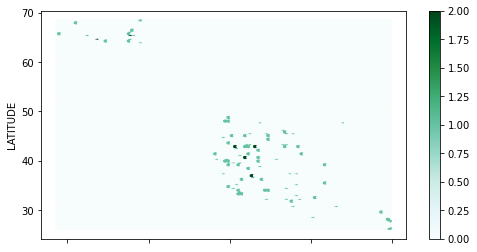

In [20]:
# Wildfire data visualization

lat_range = wildfires_data_selected['LATITUDE'].max() - wildfires_data_selected['LATITUDE'].min()
long_range = wildfires_data_selected['LONGITUDE'].max() - wildfires_data_selected['LONGITUDE'].min()
wildfires_data_selected.plot.hexbin(x='LONGITUDE', y='LATITUDE', figsize=(long_range / 10, lat_range / 10))

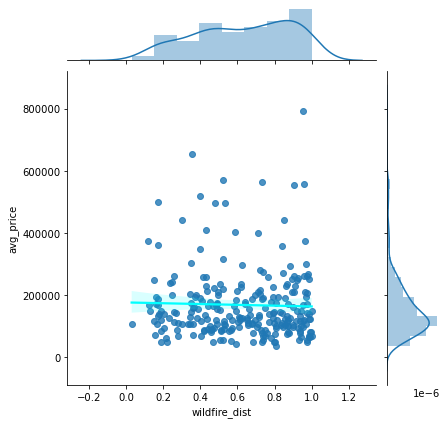

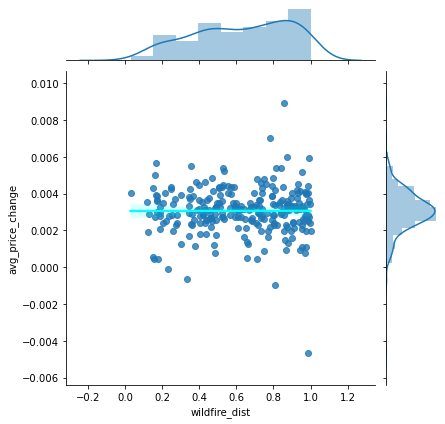

In [21]:
# Linear regression on housing distances to selected wildfires

sns.jointplot(x="wildfire_dist", y="avg_price", data=wildfire_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})

sns.jointplot(x="wildfire_dist", y="avg_price_change", data=wildfire_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})

In [22]:
# Earthquake selection

emags = range(5, 10)

earthquake_data_selected = earthquake_data[
    earthquake_data['Magnitude'].isin(emags)
].sample(300)

earthquake_data_selected

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
17184,01/08/2005,18:45:04,-55.299,-27.956,Earthquake,10.0,NaN,90.0,6.0,MWB,...,NaN,32.3,NaN,NaN,1.04,USP000DCTY,US,US,US,Reviewed
1922,05/07/1971,00:21:15,-2.751,119.690,Earthquake,26.8,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM784158,ISCGEM,ISCGEM,ISCGEM,Automatic
4063,08/21/1976,06:56:47,-6.722,129.567,Earthquake,120.0,NaN,NaN,6.0,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000HZE,US,US,US,Reviewed
12703,10/09/1995,15:35:54,19.055,-104.205,Earthquake,33.0,NaN,NaN,8.0,MW,...,NaN,NaN,NaN,NaN,1.30,USP00074VC,US,US,HRV,Reviewed
8012,06/02/1986,01:31:10,-7.015,154.484,Earthquake,15.6,4.1,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,1.00,USP0002UPE,US,US,HRV,Reviewed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,06/11/1965,03:33:47,44.608,149.022,Earthquake,40.7,NaN,NaN,7.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM855990,ISCGEM,ISCGEM,ISCGEM,Automatic
1958,06/10/1971,19:59:54,41.087,138.549,Earthquake,230.8,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM783334,ISCGEM,ISCGEM,ISCGEM,Automatic
16505,10/31/2003,01:06:28,37.812,142.619,Earthquake,10.0,NaN,568.0,7.0,MWB,...,NaN,61.2,NaN,NaN,0.80,USP000CBPA,US,US,US,Reviewed
8220,10/22/1986,08:59:29,-10.569,166.040,Earthquake,165.1,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,0.90,USP0002Z7M,US,US,HRV,Reviewed


In [23]:
# Earthquake distance calculation

calculate_distances_to_disaster(housing_data, earthquake_data_selected['Latitude'], earthquake_data_selected['Longitude'], 'earthquake_dist')

earthquake_data_selected

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
17184,01/08/2005,18:45:04,-55.299,-27.956,Earthquake,10.0,NaN,90.0,6.0,MWB,...,NaN,32.3,NaN,NaN,1.04,USP000DCTY,US,US,US,Reviewed
1922,05/07/1971,00:21:15,-2.751,119.690,Earthquake,26.8,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM784158,ISCGEM,ISCGEM,ISCGEM,Automatic
4063,08/21/1976,06:56:47,-6.722,129.567,Earthquake,120.0,NaN,NaN,6.0,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000HZE,US,US,US,Reviewed
12703,10/09/1995,15:35:54,19.055,-104.205,Earthquake,33.0,NaN,NaN,8.0,MW,...,NaN,NaN,NaN,NaN,1.30,USP00074VC,US,US,HRV,Reviewed
8012,06/02/1986,01:31:10,-7.015,154.484,Earthquake,15.6,4.1,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,1.00,USP0002UPE,US,US,HRV,Reviewed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,06/11/1965,03:33:47,44.608,149.022,Earthquake,40.7,NaN,NaN,7.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM855990,ISCGEM,ISCGEM,ISCGEM,Automatic
1958,06/10/1971,19:59:54,41.087,138.549,Earthquake,230.8,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM783334,ISCGEM,ISCGEM,ISCGEM,Automatic
16505,10/31/2003,01:06:28,37.812,142.619,Earthquake,10.0,NaN,568.0,7.0,MWB,...,NaN,61.2,NaN,NaN,0.80,USP000CBPA,US,US,US,Reviewed
8220,10/22/1986,08:59:29,-10.569,166.040,Earthquake,165.1,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,0.90,USP0002Z7M,US,US,HRV,Reviewed


In [24]:
# Housing data filter for selected wildfire

earthquake_max_dist = 6    # This dist might be far too much (~414 miles) but kept at the ~100 points

earthquake_housing_data = housing_data[
    housing_data['earthquake_dist'] < earthquake_max_dist
]

earthquake_housing_data

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,1996-01-31,...,2020-09-30,clon10,clat10,avg_price,avg_price_change,hurricane_dist,hurricane_avg_price,hurricane_avg_price_change,wildfire_dist,earthquake_dist
6037,3101,0,Los Angeles County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,37,174806.0,...,677628.0,-118.261862,34.196398,410148.074074,0.004630,28.828632,531512.604167,-0.002125,0.432241,3.468584
4013,2402,3,Maricopa County,County,AZ,AZ,Phoenix-Mesa-Scottsdale,4,13,115807.0,...,318895.0,-112.495534,33.346541,197261.474747,0.003489,23.005487,259053.916667,-0.001342,1.456946,4.540751
6073,2841,4,San Diego County,County,CA,CA,San Diego-Carlsbad,6,73,177310.0,...,632264.0,-116.776117,33.023604,404767.420875,0.004345,27.244111,512878.083333,-0.006543,0.586934,5.047449
6059,1286,5,Orange County,County,CA,CA,Los Angeles-Long Beach-Anaheim,6,59,210849.0,...,781911.0,-117.777207,33.675687,519113.239057,0.004478,28.294684,664710.395833,-0.003771,0.399262,4.086190
6065,2832,10,Riverside County,County,CA,CA,Riverside-San Bernardino-Ontario,6,65,138091.0,...,419702.0,-116.002239,33.729828,277634.942761,0.003827,26.532889,396193.208333,-0.006745,1.016322,4.834029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53069,2868,2905,Wahkiakum County,County,WA,WA,NaN,53,69,NaN,...,257907.0,-123.424458,46.294638,176837.104396,0.003256,36.897860,171851.682927,0.004055,2.517808,5.802992
6091,1391,2957,Sierra County,County,CA,CA,NaN,6,91,NaN,...,247046.0,-120.521993,39.576925,213404.276699,0.001785,32.062874,235567.604167,-0.003502,0.436009,2.558632
2100,1073,3004,Haines Borough,County,AK,AK,NaN,2,100,NaN,...,232427.0,-135.578102,59.099905,208228.530201,0.000695,53.065255,210730.125000,-0.000641,8.089577,4.916543
32011,1008,3052,Eureka County,County,NV,NV,Elko,32,11,NaN,...,176510.0,-116.272208,39.977788,120081.018293,0.003263,28.110884,103988.478261,-0.005792,0.695386,3.529626


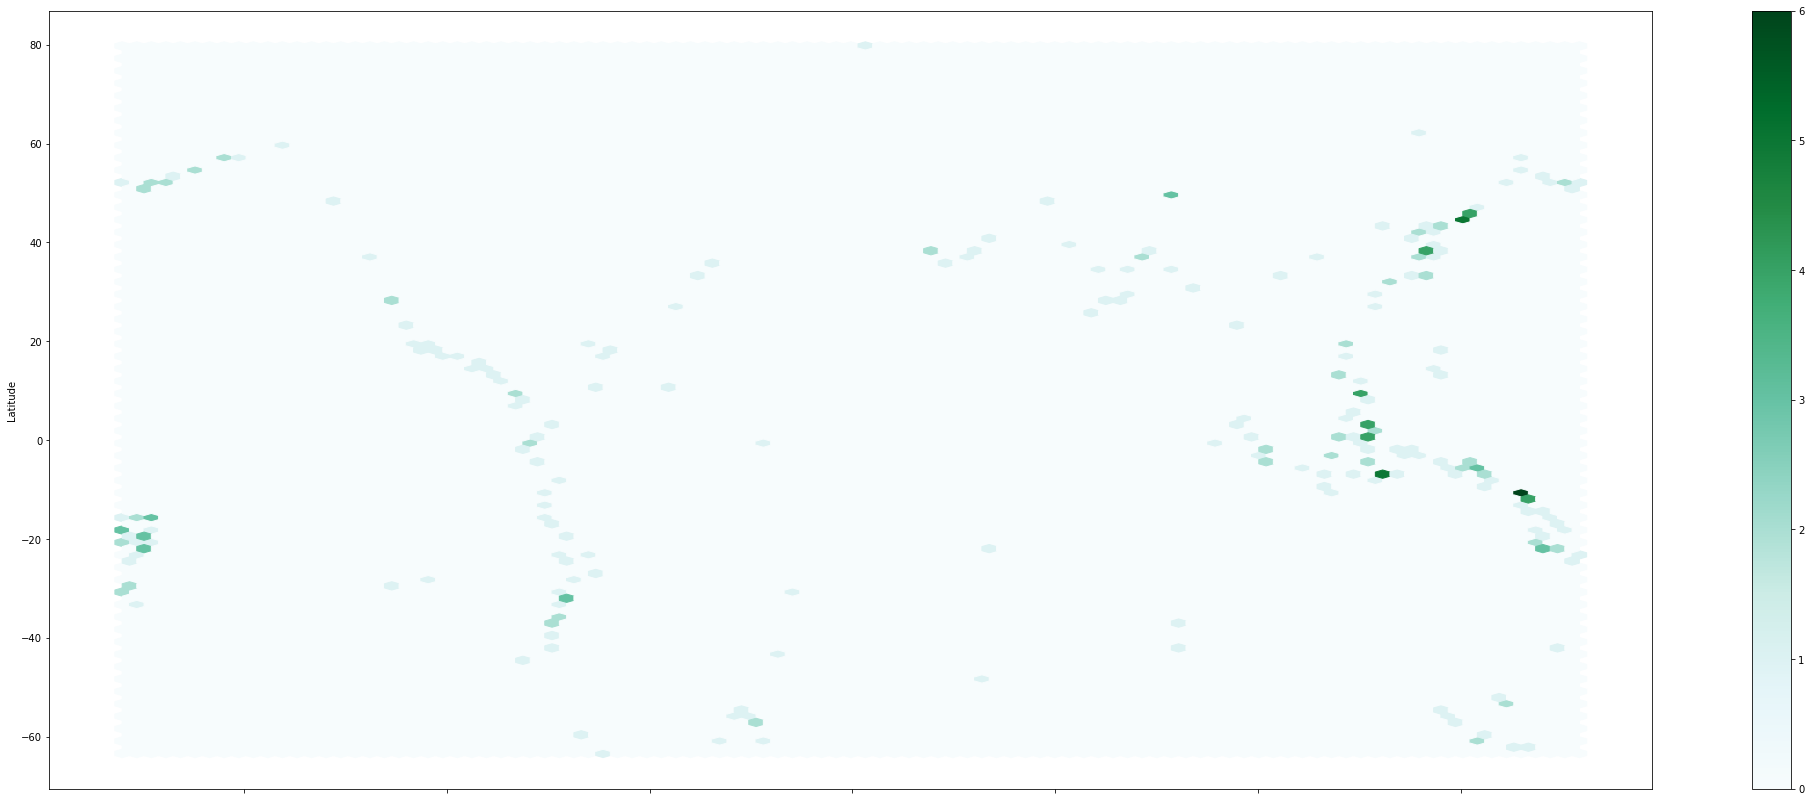

In [25]:
# Earthquake data visualization

lat_range = earthquake_data_selected['Latitude'].max() - earthquake_data_selected['Latitude'].min()
long_range = earthquake_data_selected['Longitude'].max() - earthquake_data_selected['Longitude'].min()
earthquake_data_selected.plot.hexbin(x='Longitude', y='Latitude', figsize=(long_range / 10, lat_range / 10))

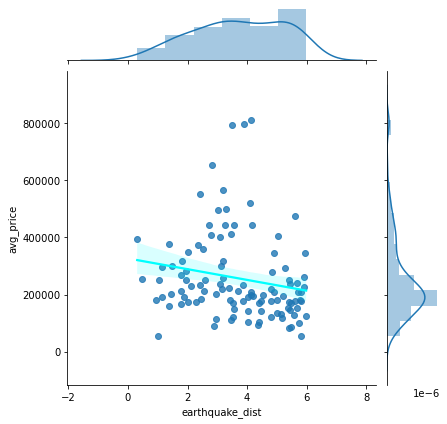

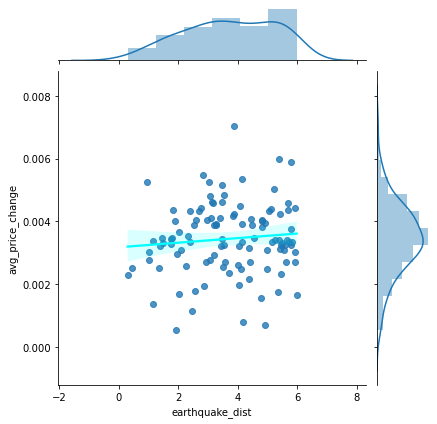

In [26]:
# Linear regression on housing distances to selected Earthquakes

sns.jointplot(x="earthquake_dist", y="avg_price", data=earthquake_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})

sns.jointplot(x="earthquake_dist", y="avg_price_change", data=earthquake_housing_data, kind='reg', joint_kws={'line_kws':{'color':'cyan'}})